## **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. Hence as an example for 2 students:
12301230_3434343_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Kacper Sawicz"
NAME2 = "Reinier Bekkenutte"
EMAIL = "kacper.sawicz1@gmail.com"
EMAIL2 = "reinierbekkenutte@hotmail.com"

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, September/October 2020

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$. You can make use of `np.random.normal()` (Hint: Double check its input parameters).


In [4]:
def gen_sine(n):
    # YOUR CODE HERE
    x = np.linspace(0, 2*math.pi, n, endpoint=True)
    t = np.random.normal(loc=sin(x), scale = 0.25)
    
    return x, t


In [5]:
x,t = gen_sine(10)

In [6]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [7]:
def designmatrix(x, M): # it is highly recommended to write a helper function that computes Phi
    Phi = np.zeros((len(x),M+1))
    for m in range(0,M+1):
        for i in range(len(x)):
            Phi[i,m] = x[i]**m
    #raise NotImplementedError()
    return Phi


def fit_polynomial(x, t, M):
    Phi = designmatrix(x, M)
    w_ml = np.linalg.inv(np.transpose(Phi) @ Phi) @ np.transpose(Phi) @ t

    return w_ml, Phi

In [8]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

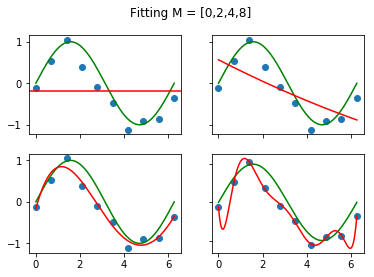

In [9]:
N = 10
x, t = gen_sine(N)
x_full = np.linspace(0, 2*pi, 10000, endpoint=True)

w_0 = fit_polynomial(x, t, 0)[0]
w_2 = fit_polynomial(x, t, 2)[0]
w_4 = fit_polynomial(x, t, 4)[0]
w_8 = fit_polynomial(x, t, 8)[0]

def predictionfunction(w, x):
    y = 0
    for i in range(0, len(w)):
        y = y + w[i]*x**i
    return y

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Fitting M = [0,2,4,8]')
ax1.plot(x, t, 'o')
ax1.plot(x_full, sin(x_full), color='g')
ax1.axhline(y=w_0, color='r')
ax2.plot(x, t, 'o')
ax2.plot(x_full, sin(x_full), color='g')
ax2.plot(x_full, predictionfunction(w_2, x_full), color='r')
ax3.plot(x, t, 'o')
ax3.plot(x_full, sin(x_full), color='g')
ax3.plot(x_full, predictionfunction(w_4, x_full), color='r')
ax4.plot(x, t, 'o')
ax4.plot(x_full, sin(x_full), color='g')
ax4.plot(x_full, predictionfunction(w_8, x_full), color='r')

for ax in fig.get_axes():
    ax.label_outer()

### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [10]:
def fit_polynomial_reg(x, t, m, lamb):
    # YOUR CODE HER
    Phi = designmatrix(x, m)
    w_ml = np.linalg.inv(lamb * np.identity(m+1) + (np.transpose(Phi) @ Phi)) @ np.transpose(Phi) @ t
    
    return w_ml, Phi


In [11]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x^2 + 2.5$)

ANSWER =
After introducing regularization term the Phi does not change. It is the case, since the designmatrix function 
we are using, does not include the lambda in the Phi calculation, we are using still the same x for it. 
In vector w we can see a decrease in coefficients towards 0 (if its positive it gets smaller, if its negative it gets bigger), 
this is a result of regularization term which controls for the over-fitting.







### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [12]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    # YOUR CODE HERE
    w_ml = fit_polynomial_reg(x_train, t_train, M, reg)[0]
    predictions = predictionfunction(w_ml, x_valid)
    pred_err = 0
    for i in range(0,len(t_valid)):
        pred_err = pred_err + (t_valid[i] - predictions[i])**2
    return pred_err


In [13]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [14]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [15]:
def find_best_m_and_lamb(x, t):
    # YOUR CODE HERE
    PossibleM = np.linspace(0, 10, 11)
    exponents = np.linspace(-10,0,11)
    PossibleLambda = exp(exponents)
    kfold_ind = kfold_indices(len(x), 5)
    error = 0
    for m in PossibleM:
        for lamb in PossibleLambda:
            fold_error_sum = 0
            for fold in range(0,5):
                x_train = []
                t_train = []
                x_valid = []
                t_valid = []
                train_indices = kfold_ind[0][fold]
                valid_indices = kfold_ind[1][fold]
                for i in train_indices:
                    x_train.append(x[i])
                    t_train.append(t[i])
                for j in valid_indices:
                    x_valid.append(x[j])
                    t_valid.append(t[j])
                x_train=np.array(x_train)
                t_train=np.array(t_train)
                x_valid = np.array(x_valid)
                t_valid=np.array(t_valid)
                fold_error_sum = fold_error_sum + pred_error(x_train, x_valid, t_train, t_valid, int(m), lamb)
            fold_error_avg = fold_error_sum/5
            if(error == 0):
                error = fold_error_avg
                M_best = m
                lamb_best = lamb
            elif(error > fold_error_avg):
                error = fold_error_avg
                M_best = m
                lamb_best = lamb
    return M_best, lamb_best

In [16]:
### This is not an empty cell (You don't need to care about it).

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

ANSWER = Running only 20 runs with one parameter fixed and then the other one, having initial ones initialized randomly, is a bad idea, since we are not investigating the cross influence of the parameters. While running 100 loops we investigate all of the cross influences as well as the individual ones, so even tho it is not the most efficient way od doing it, we have all the needed information at the end.

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

ANSWER = A better way of optimising hyper-parameters is Bayesian optimisation. It is caused by its ability to reason about the quality of an experiment, before it is run. It achieves it by the balance between the exploitation and exploration, which allows it to finds the hyper-parametrs in less runs than the grid search.

### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

The green line is the true Sine function, the red line is the model we found with parameters:
m =  4.0
l =  0.0183156388887


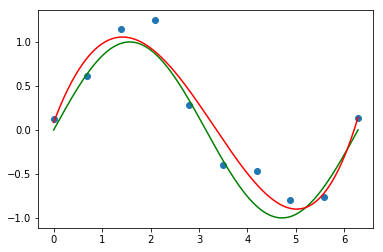

In [17]:
# YOUR CODE HERE
np.random.seed(42)
N = 10
x, t = gen_sine(N)
m , l =  find_best_m_and_lamb(x, t)
w = fit_polynomial_reg(x, t, int(m), l)[0]

plt.plot(x, t, 'o') 
plt.plot(x_full, sin(x_full), color='g')
plt.plot(x_full, predictionfunction(w, x_full), color='r')
print('The green line is the true Sine function, the red line is the model we found with parameters:')
print('m = ', m)
print('l = ', l)




## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [18]:
def gen_sine2(n):
    # YOUR CODE HERE
    x = np.random.uniform(0,2*pi,n)
    t = np.random.normal(loc=sin(x), scale = 0.25)
    return x, t


In [19]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [20]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    # YOUR CODE HERE
    Phi = designmatrix(x, M)
    S = np.linalg.inv(alpha * np.identity(M+1) + beta*((np.transpose(Phi) @ Phi)))
    m = beta *  S @ np.transpose(Phi) @ t
    return m, S, Phi


In [21]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [22]:
def predict_polynomial_bayes(x, m, S, beta):
    # YOUR CODE HERE
    Phi = designmatrix(x,m.shape[0]-1)
    mean = np.zeros(len(x))
    sigma = np.zeros(len(x))
    for i in range(len(x)):
            mean[i] = np.transpose(m) @ Phi[i,]
            sigma[i] = (1/beta) + np.transpose(Phi[i,])@ S @ Phi[i,]
    return mean, sigma, Phi


In [23]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


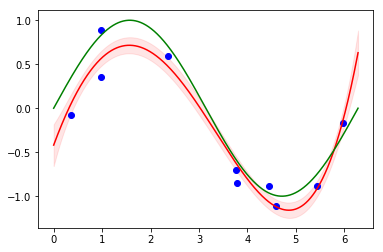

In [24]:
# YOUR CODE HERE
np.random.seed(42)
x, t = gen_sine2(10)
m , S , phi = fit_polynomial_bayes(x, t, 4, 2/5, 1/0.25**2)
x_full = np.linspace(0, 2*pi, 10000, endpoint=True)
mean, sigma, Phi = predict_polynomial_bayes(x_full, m, S, 1/0.25**2)
plt.plot(x,t, 'bo')
plt.plot(x_full, mean, color='r')
plt.plot(x_full, sin(x_full), color='g')
plt.fill_between(x_full, mean-sigma, mean+sigma, alpha=0.1, color='r')



b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


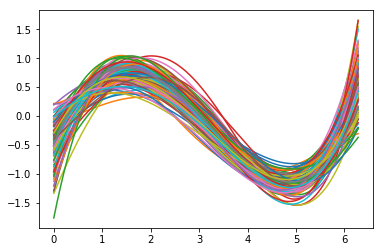

In [25]:
# YOUR CODE HERE
np.random.seed(42)
x, t = gen_sine2(10)
x_full = np.linspace(0, 2*pi, 10000, endpoint=True)
i = 0
while (i < 100):
    m , S , phi = fit_polynomial_bayes(x, t, 4, 2/5, 1/0.25**2)
    w = np.random.multivariate_normal(m, S, 1)
    w = np.transpose(w)
    plt.plot(x_full,predictionfunction(w, x_full))
    i = i + 1



### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=16$ the best choice of $\beta$ in section 2.4?



ANSWER = Because the SD of t is 0.25, we know that the variance in our data is 0.25^2, so that means that the beta coefficient has to correspond to 1/variance which is 16.

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

ANSWER = Because the SD of t is 0.25, we know that the variance in our data is 0.25^2, so that means that the beta coefficient has to correspond to 1/variance which is 16.